In [1]:
import scipy
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from nibabel import freesurfer as fs
import networkx as nx
from fastconsensus.core import construct_sparse_consensus_matrix,threshold_matrix,triadic_closure,check_convergence,get_algorithm
import igraph as ig
from bct.algorithms.centrality import participation_coef, module_degree_zscore
from copy import deepcopy

%load_ext rpy2.ipython

In [2]:
%%R

suppressPackageStartupMessages({
    library(cowplot)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

## Load overlapping community detection algorithm (OCDA) modules

In [3]:
# Read in OCDA modules
oslom_modules_final_glasser180_right = pd.read_csv(f"../data/OSLOM30_final_module_assignments.csv").drop(columns=['node'])
oslom_modules_final_glasser180_right_long = pd.read_csv(f"../data/OSLOM30_final_module_assignments_with_duplicates.csv").drop(columns=['node'])

# Load module orders
module_orders = pd.read_csv("../data/module_orders_OSLOM30.csv")

# Define data path
data_path = "/Users/abry4213/data/OCDA/"

# Convert oslom_modules_final_glasser180_right_long to a wide format, with each row correspoding to a region and each column to a module
# Values should be 1 if the region is in the module, 0 otherwise
oslom_modules_final_glasser180_right_wide = oslom_modules_final_glasser180_right_long.assign(value=1).pivot(index='Glasser_RH_ROI', columns='module', values='value').fillna(0)
oslom_modules_final_glasser180_right_wide.to_csv("../data/OSLOM30_final_module_assignments_wide_binary.csv", index=False, header=False)

# Load brain region labels
brain_regions = pd.read_csv("../data/brain_area_labels.csv", header=None, names=['node', 'Glasser_RH_ROI']).drop('node', axis=1)
brain_regions['node_index'] = range(1, brain_regions.shape[0]+1)

# Filter to node_index<=180 and drop node_index 92
brain_regions = brain_regions[brain_regions['node_index']<=180]
brain_regions = brain_regions[brain_regions['node_index']!=92]

# Load brain region names
region_names = brain_regions.Glasser_RH_ROI.values

# Loading community structure as determined by Louvain
louvain_consensus_results = pd.read_csv("../data/louvain_community_assignments_BCT_gamma1.csv").assign(Glasser_RH_ROI=region_names)

# Load right-hemisphere connectivity matrix
RH_connectivity_data = pd.DataFrame(scipy.io.loadmat('../data/RH.mat')['RH'])

# Drop column/row 91
RH_connectivity_data = RH_connectivity_data.drop(index=91, columns=91)

# Assign region names to rows and columns
RH_connectivity_data.index = region_names
RH_connectivity_data.columns = region_names

# Load right-hemisphere connectivity matrix, with added nodes for OSLOM overlap
RH_connectivity_data_overlap = pd.DataFrame(scipy.io.loadmat('../data/RH_new.mat')['RH_with_duplicates'])

# Load results with duplicates for OSLOM
oslom_modules_final_glasser180_right = pd.read_csv("../data/OSLOM30_final_module_assignments.csv")
oslom_modules_final_glasser180_right_long = pd.read_csv("../data/OSLOM30_final_module_assignments_with_duplicates.csv")
oslom_modules_final_glasser180_right_long = oslom_modules_final_glasser180_right_long.merge(oslom_modules_final_glasser180_right[['Glasser_RH_ROI', 'overlapping']], on='Glasser_RH_ROI', how='left')
OSLOM_final_results_long = pd.read_csv("../data/OSLOM30_final_module_assignments_with_duplicates.csv")

In [4]:
%%R -i region_names,oslom_modules_final_glasser180_right,louvain_consensus_results -o oslom_modules_final_glasser180_right,louvain_consensus_results

oslom_modules_final_glasser180_right <- oslom_modules_final_glasser180_right %>% 
    mutate(Glasser_RH_ROI = factor(Glasser_RH_ROI, levels=region_names)) %>% 
    arrange(Glasser_RH_ROI)

louvain_consensus_results <- louvain_consensus_results %>%
    mutate(Glasser_RH_ROI = factor(Glasser_RH_ROI, levels=region_names)) %>%
    arrange(Glasser_RH_ROI)

In [5]:
# Read in Glasser 180 right hemisphere
glasser180_right_file = "/Users/abry4213/data/neuroimaging_atlases/surfaces/Glasser_2016/fsaverage/rh.HCP-MMP1.annot"
glasser180_right_vertices, glasser180_right_ctab, glasser180_right_names = fs.read_annot(glasser180_right_file)

glasser180_right_vertices = glasser180_right_vertices
glasser180_right_ctab = glasser180_right_ctab
glasser180_right_names = [name.decode() for name in glasser180_right_names if name.decode() != '???']

# Create Glasser 180 right hemi lookup table
glasser180_right_LUT = pd.DataFrame({'index': np.arange(0, len(glasser180_right_names)), 'Glasser_RH_ROI': glasser180_right_names})

# Convert glasser array to dataframe
glasser180_right_df = pd.DataFrame({'index': glasser180_right_vertices, 'vertex_number': np.arange(0, len(glasser180_right_vertices))})
glasser180_right_df['Glasser_RH_ROI'] = glasser180_right_df['index'].map(glasser180_right_LUT.set_index('index')['Glasser_RH_ROI'])

# Drop index
glasser180_right_df = glasser180_right_df.drop(columns=['index'])

## Compute participation coefficient (P) and module degree, z-scored (Z)

In [6]:
louvain_P = participation_coef(RH_connectivity_data.values, louvain_consensus_results['Louvain_community'].values)
oslom_P = participation_coef(RH_connectivity_data_overlap.values, OSLOM_final_results_long['module'].values)

louvain_Z = module_degree_zscore(RH_connectivity_data.values, louvain_consensus_results['Louvain_community'].values)
oslom_Z = module_degree_zscore(RH_connectivity_data_overlap.values, OSLOM_final_results_long['module'].values)

louvain_structure_df = (louvain_consensus_results
                        .merge(oslom_modules_final_glasser180_right[['Glasser_RH_ROI', 'overlapping', 'module']], 
                               on="Glasser_RH_ROI", how="left")
                        .assign(louvain_P=louvain_P, louvain_Z=louvain_Z)
                        .rename(columns={'module': 'OSLOM_module'})
                        )

oslom_structure_df = (OSLOM_final_results_long
                      .assign(oslom_P = oslom_P, oslom_Z = oslom_Z)
                      )

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/bct/algorithms/centrality.py:687: RuntimeWarning: invalid value encountered in divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


### Plot Z vs. P for Louvain

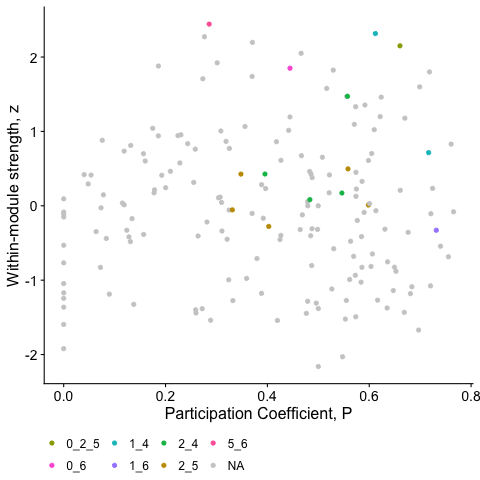

In [35]:
%%R -i louvain_structure_df,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

louvain_structure_df %>% 
    mutate(row_index = row_number()) %>%
    mutate(color_module = ifelse(overlapping=='overlapping', OSLOM_module, NA_character_)) %>%
    ggplot(data=., mapping=aes(x=louvain_P, y=louvain_Z, color=color_module)) +
    geom_point(size=1.7) + 
    ylab("Within-module strength, z") +
    xlab("Participation Coefficient, P") +
    scale_color_manual(values=colormap, na.value="gray80") +
    theme(legend.position="bottom",
          axis.title = element_text(size=16),
          axis.text = element_text(size=14),
          legend.title=element_blank())
# ggsave("../Plots/Louvain_community_stats.svg", width=4, height=4.5, units="in", dpi=300)

Joining with `by = join_by(Glasser_RH_ROI)`


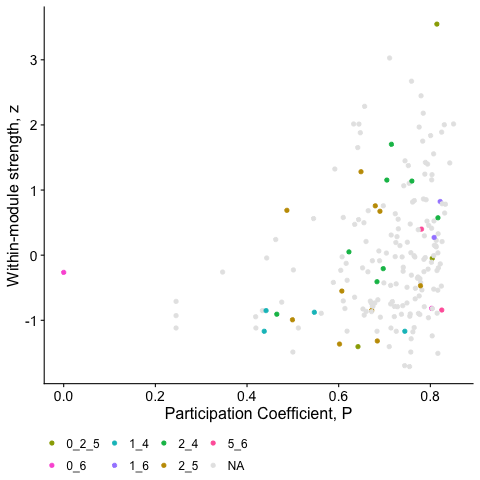

In [15]:
%%R -i oslom_structure_df,oslom_modules_final_glasser180_right

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

oslom_structure_df %>% 
    mutate(row_index = row_number()) %>%
    left_join(., oslom_modules_final_glasser180_right %>% rename('OSLOM_module' = 'module') %>% select(Glasser_RH_ROI, overlapping, OSLOM_module)) %>%
    mutate(color_module = ifelse(overlapping=='overlapping', OSLOM_module, NA_character_)) %>%
    ggplot(data=., mapping=aes(x=oslom_P, y=oslom_Z, color=color_module)) +
    geom_point(size=1.7) + 
    ylab("Within-module strength, z") +
    xlab("Participation Coefficient, P") +
    scale_color_manual(values=colormap, na.value="gray90") +
    theme(legend.position="bottom",
          axis.title = element_text(size=16),
          axis.text = element_text(size=14),
          legend.title=element_blank())
# ggsave("../Plots/OSLOM_community_stats.svg", width=4, height=4.5, units="in", dpi=300)

## Compare p/Z in Louvain vs. OSLOM space

In [36]:
P_z_data_to_plot = (oslom_structure_df[['Glasser_RH_ROI', 'oslom_P', 'oslom_Z']]
                  .merge(louvain_structure_df[['Glasser_RH_ROI', 'louvain_P', 'louvain_Z']], 
                         on='Glasser_RH_ROI', how='left')
                    .assign(P_diff = lambda x: x.oslom_P - x.louvain_P,
                                Z_diff = lambda x: x.oslom_Z - x.louvain_Z)
                    .merge(louvain_structure_df, on=['Glasser_RH_ROI', 'louvain_P', 'louvain_Z'])
                    .query("overlapping == 'overlapping'")
                                )


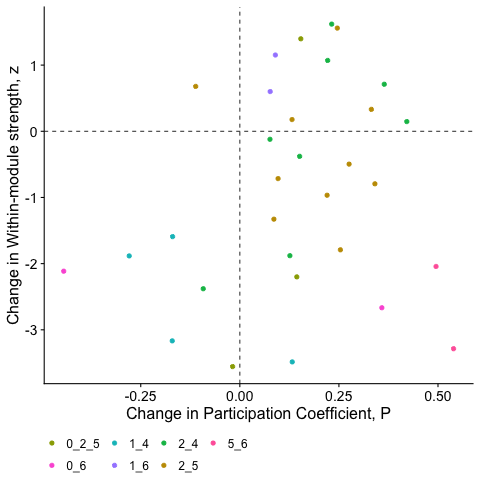

In [37]:
%%R -i P_z_data_to_plot,module_orders

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Number)

P_z_data_to_plot %>% 
    mutate(label_short = gsub("R_|_ROI", "", Glasser_RH_ROI)) %>%
    ggplot(data=., mapping=aes(x=P_diff, y=Z_diff, color=OSLOM_module)) +
    geom_hline(yintercept=0, linetype="dashed", linewidth=0.4) +
    geom_vline(xintercept=0, linetype="dashed", linewidth=0.4) +
    geom_point(size=1.7) +
    # geom_text(aes(label=label_short), size=2, nudge_y=0.1) +
    ylab("Change in Within-module strength, z") +
    xlab("Change in Participation Coefficient, P") +
    scale_color_manual(values=colormap, na.value="gray90") +
    theme(legend.position="bottom",
            axis.title = element_text(size=16),
            axis.text = element_text(size=14),
            legend.title=element_blank())
# ggsave("../Plots/Delta_P_vs_z_partitions.svg", width=3, height=4, units="in", dpi=300)

In [38]:
# How many nodes are assigned to each Louvain community?
louvain_structure_df.groupby('Louvain_community').size()

Louvain_community
1    29
2     2
3    46
4    36
5    10
6    56
dtype: int64

## Compare 9m community assignment in Louvain vs. OSLOM

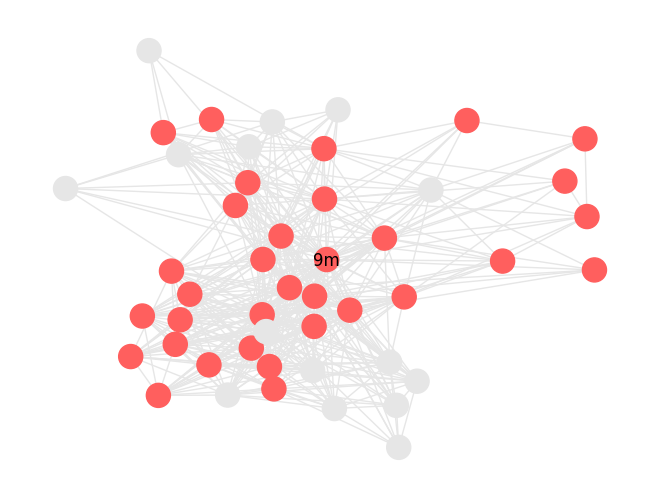

In [24]:
# What region do we want? ProS
target_region_to_plot = "R_9m_ROI"
target_region_index = region_names.index(target_region_to_plot)

# Keep all edges that connect to node 127 (with base 0, after removing node 92, that's node 125 in Python)
RH_connectivity_arr = np.array(RH_connectivity_data)
keepNode = RH_connectivity_arr[target_region_index, :] > 0
keepNode[target_region_index] = True

# Subset region_labels to only include nodes in the subnetwork
region_names_sub = [d for d, m in zip(region_names, keepNode) if m]

# Convert to a dataframe
region_names_sub = pd.DataFrame(region_names_sub, columns=['Glasser_RH_ROI'])
region_names_sub['index_sub'] = range(len(region_names_sub))
target_region_index_sub = region_names_sub.query("Glasser_RH_ROI == @target_region_to_plot").index_sub.values[0]

# Subset RH_connectivity_arr rows and columns to only the indices in keepNode that are 1
RH_connectivity_arr_sub = RH_connectivity_arr[keepNode, :][:, keepNode]

numNodes = RH_connectivity_arr_sub.shape[0]

# Filter community assignments to only include nodes in the subnetwork
oslom_subset = oslom_modules_final_glasser180_right.query("Glasser_RH_ROI in @region_names_sub.Glasser_RH_ROI").assign(node_index = range(numNodes))
louvain_subset = louvain_structure_df.query("Glasser_RH_ROI in @region_names_sub.Glasser_RH_ROI").assign(node_index = range(numNodes))

# Highlighting the nodes belonging to community 0 which is split into several communities by OSLOM
nodes_louvain_cluster2 = louvain_subset.query("Louvain_community == 2").node_index.tolist()
nodes_louvain_other = louvain_subset.query("Louvain_community != 2").node_index.tolist()

# Set the seed for a reproducible network graph
np.random.seed(127)

# Create a network graph from the subsetted adjacency matrix
G_louvain = nx.Graph(RH_connectivity_arr_sub)

# Get short names
region_names_sub_short = region_names_sub.Glasser_RH_ROI.str.replace("R_", "").str.replace("_ROI", "").values

# Color nodes by community in G
labels = {}    
color_map = []
for node in G_louvain:
    if node == target_region_index_sub:
        labels[node] = region_names_sub_short[node]
    if node in nodes_louvain_cluster2:
        color_map.append('#FF5F5E')
    else: 
        color_map.append('#E6E6E6')      
nx.draw(G_louvain, node_color=color_map, edge_color='#E6E6E6', with_labels=True,labels=labels)
plt.savefig("../Plots/Louvain_9m_network_graph.svg", format="SVG")


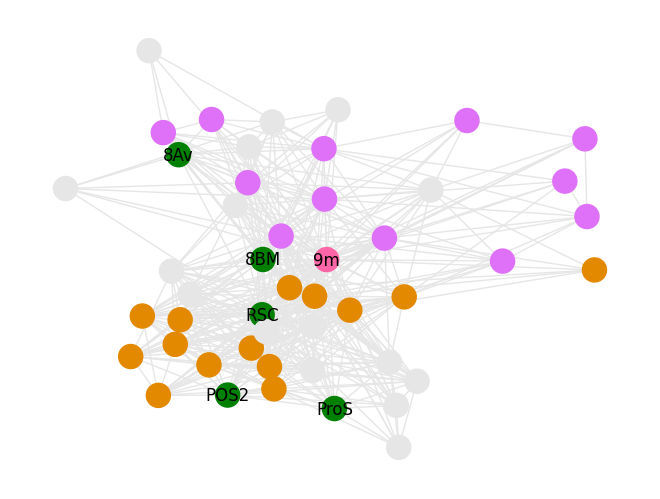

In [25]:
# Set the seed for a reproducible network graph
np.random.seed(127)

oslom_module_overlap = oslom_subset.query("Glasser_RH_ROI == @target_region_to_plot").module.values[0]
oslom_module_1 = oslom_module_overlap.split("_")[0]
oslom_module_2 = oslom_module_overlap.split("_")[1]

# Highlighting the nodes belonging to community 0 which is split into several communities by OSLOM
nodes_oslom_overlap = oslom_subset.query("module == @oslom_module_overlap").node_index.tolist()
nodes_oslom_1 = oslom_subset.query("module == @oslom_module_1").node_index.tolist()
nodes_oslom_2 = oslom_subset.query("module == @oslom_module_2").node_index.tolist()
nodes_oslom_overlap_other = oslom_subset.query("module.str.contains('_') and module != @oslom_module_overlap").node_index.tolist()

# Create a network graph from the subsetted adjacency matrix
G_oslom = nx.Graph(RH_connectivity_arr_sub)

# Color nodes by community in G
labels = {}    
color_map = []

for node in G_oslom:
    # Color maps
    if node in nodes_oslom_1:
        color_map.append('#e38900')
    elif node in nodes_oslom_2:
        color_map.append('#df70f8')
    elif node in nodes_oslom_overlap:
        color_map.append('#ff66a8')
        # Also append label
        labels[node] = region_names_sub_short[node]
    elif node in nodes_oslom_overlap_other:
        color_map.append('green')
        labels[node] = region_names_sub_short[node]
    else: 
        color_map.append('#E6E6E6')     
nx.draw(G_oslom, node_color=color_map, edge_color='#E6E6E6', with_labels=True,labels=labels)
plt.savefig("../Plots/OSLOM_9m_network_graph.svg", format="SVG")

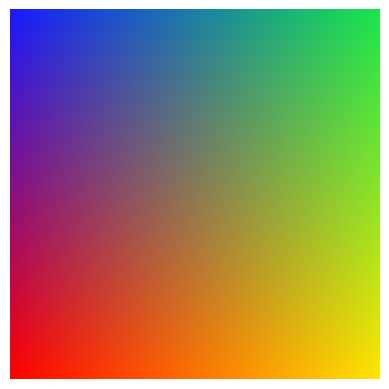

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the corner colors in RGB (reshaped for broadcasting)
top_left = np.array([1, 0, 0]).reshape(1, 1, 3)   # Red
top_right = np.array([1, 0.9, 0]).reshape(1, 1, 3)  # Yellow
bottom_right = np.array([0.1, 0.9, 0.3]).reshape(1, 1, 3) # Green
bottom_left = np.array([0.1, 0.1, 1]).reshape(1, 1, 3) # Blue

# Define the resolution of the image
size = 500  # 500x500 pixels
X, Y = np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))

# Reshape X and Y to allow broadcasting with color arrays
X = X[:, :, np.newaxis]  # Shape (500, 500, 1)
Y = Y[:, :, np.newaxis]  # Shape (500, 500, 1)

# Interpolate colors
top = top_left * (1 - X) + top_right * X
bottom = bottom_left * (1 - X) + bottom_right * X
gradient = bottom * (1 - Y) + top * Y

# Display the gradient
plt.imshow(gradient)
plt.axis('off')  # Hide the axis
plt.savefig("../Plots/Louvain_gradient.svg", format="SVG")

### Do PG1 values relate to OSLOM z/P?

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel import freesurfer as fs
import neuromaps
from neuromaps.datasets import fetch_annotation
from neuromaps import transforms

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

# Download Margulies principal gradient for right hemisphere
margulies_PG1 = fetch_annotation(source='margulies2016', desc='fcgradient01')
margulies_PG1_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG1, '164k', 'R')[0]
margulies_PG1_fsaverage_right_vertices = margulies_PG1_fsaverage_right.agg_data()

margulies_PG2 = fetch_annotation(source='margulies2016', desc='fcgradient02')
margulies_PG2_fsaverage_right = transforms.fslr_to_fsaverage(margulies_PG2, '164k', 'R')[0]
margulies_PG2_fsaverage_right_vertices = margulies_PG2_fsaverage_right.agg_data()

# Combine PG1 and PG2 across vertices
margulies_PG_fsaverage_right_df = pd.DataFrame({'PG1_value': margulies_PG1_fsaverage_right_vertices, 
                                                'PG2_value': margulies_PG2_fsaverage_right_vertices, 
                                                'vertex_number': np.arange(0, len(margulies_PG1_fsaverage_right_vertices))})


# Create a merged df
merged_df = glasser180_right_df

# Merge with OCDA modules
merged_df = pd.merge(merged_df, oslom_modules_final_glasser180_right, on='Glasser_RH_ROI', how='left')

# Merge with margulies principal gradient
merged_df = pd.merge(merged_df, margulies_PG_fsaverage_right_df, on='vertex_number', how='left')

# Mean PG1 value by region
mean_PG_value_by_region = (merged_df
                            .groupby(['Glasser_RH_ROI'])[['PG1_value', 'PG2_value']]
                            .mean()
                            .reset_index()
                            .merge(oslom_modules_final_glasser180_right, how='left'))

PG_values_vs_nodal_stats = mean_PG_value_by_region.drop(['node', 'module'], axis=1).merge(oslom_structure_df, on=['Glasser_RH_ROI'], how='left')

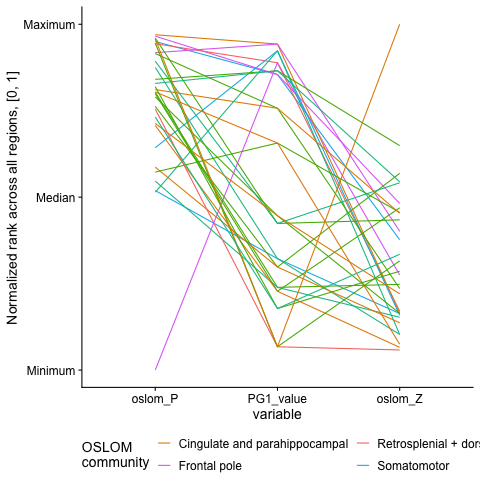

In [43]:
%%R -i PG_values_vs_nodal_stats,module_orders -o relative_nodal_ranks

# Convert to named vector
colormap <- setNames(module_orders$Color, module_orders$Module_Name)

relative_nodal_ranks <- PG_values_vs_nodal_stats %>% 
    pivot_longer(cols=c("PG1_value", "oslom_P", "oslom_Z"), names_to="variable", values_to="value") %>%
    mutate(node__module = paste(Glasser_RH_ROI, module, sep="_"),
           module = as.factor(module)) %>%
    left_join(., module_orders, by=c("module"="Module_Number")) %>%
    # Min-max normalize values within each variable
    group_by(variable) %>%
    mutate(value = (value - min(value, na.rm=T)) / (max(value, na.rm=T) - min(value, na.rm=T))) %>%
    ungroup() %>% 
    mutate(variable = factor(variable, levels=c("oslom_P", "PG1_value", "oslom_Z"))) %>%
    filter(overlapping == 'overlapping') 
    
relative_nodal_ranks %>%
    ggplot(data=., mapping=aes(x=variable, y=value, group=node__module, color=Module_Name)) +
    labs(color="OSLOM\ncommunity") +
    ylab("Normalized rank across all regions, [0, 1]") +
    scale_color_manual(values=colormap) +
    scale_y_continuous(breaks=c(0, 0.5, 1), labels=c("Minimum", "Median", "Maximum")) +
    geom_line() +
    theme(legend.position="bottom")